<a href="https://colab.research.google.com/github/schwartz-cnl/Computational-Neuroscience-Class/blob/main/Project%20Option%201%20Neural%20Fitting/Neural_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural fitting

by Xu Pan and Odelia Schwartz, 2022.

As we discussed in the class, convolutional neural networks (CNNs) share a good deal of properties with the visual cortex. A recent trend in research is using different methods to compare CNNs with the visual cortex. One straightforward method is fitting neural responses with CNN activations. More specifically, we give the same stimuli to a CNN and subjects, extract intermediate layer activations as features, then fit features to the neural responses recorded from subjects (see figure below). Once a regression model is trained, we can predict the neural responses to novel stimuli. This method is called voxel-wise encoding model (voxel is a term from fMRI studies. However the same principle can be applied to any other neural data, e.g. EEG, electrophysiology.).

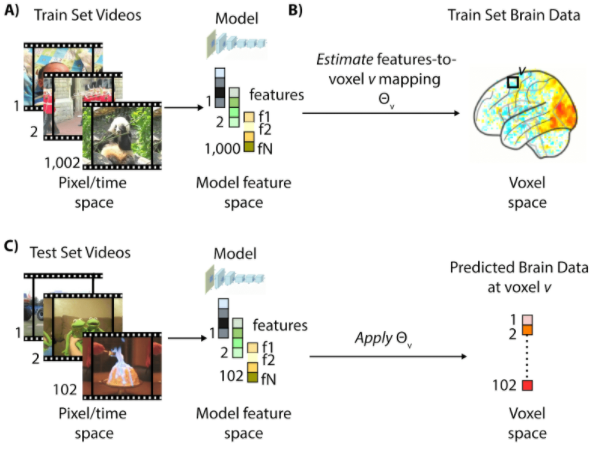

Figure (from ALGONAUTS 2021. They used video stimuli and voxels. In our case, we used images and simulated data.): A) First, given the training set videos, the features of a computational model are extracted. B) A mapping between model features and brain voxels is estimated from the Training Set videos. C) A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.


---

In this project, we provide you with "neural responses" of 5 simulated neurons to 280 images (they are neurons in a artificial neural network, though you should treat them as 5 real neurons or 5 voxels in fMRI recordings). We separated 280 (image, response) pairs into a training set (200 images) and a testing set (80 images).

This project could be considered as a data science problem/competition, and it is also commonly used in computational neuroscience. Basic knowledge about data science and regression models is necessary for this project. You need to train a regression model using some CNN features to predict responses of 5 neurons. **Only training set responses is available to you, and you need to separate it into your own training set and validation set, and ideally with cross-validation.** When you are satisfied with your model, use the model to predict neural responses to 80 test images and submit the predictions to us. We will evaluate your predictions with the hidden test set ground truth, as typical in competitions.

This is a common paradigm for data science competitions. Actually we structured it based on a real competition, i.g. THE ALGONAUTS PROJECT. However, we don't really grade your final project based on your prediction performance, neither this is a true competition...

---

A simple tutorial is attached below. And here are some tips that may help you design your regression model.


1.   Use **VGG16** features. However, you are free to explore other CNNs features.
2.   You can use traditional regression methods, such as **Lasso regression and Ridge regression**. Try different **alpha** values. Scikit-learn package is very useful. Alternatively, you can train a **neural network regressor**.
3.   You can **use one layer at a time as your features**, and you can explore which layer is the best. For example, in the tutorial, I use activations in "block2_conv1" as my feature.
4.   Because of the limited data and the high dimensionality of features, It is good to do a **spatial pooling** before using the features. There are different ways to do pooling, e.g. max pooling and average pooling, and you can try different pool sizes. Try to explore these hyperparameters. They are important to good regression performance.
5.   **Cross-validate** your model, i.e. split train-validation sets multiple times. Scikit-learn has built-in functions for cross-validation.
6.   You will have an over-fitting problem. It is very hard to avoid it when dealing with high-dimentional data. As long as you are doing cross-validation, you can trust your averaged validation score.

7.   0.15 is a ok score. 0.3 is a very good score. Some neurons are more difficult to fit. You may want to fit different neurons with different regression models to gain better overall fitness.

---

Relevant references:

1.   THE ALGONAUTS PROJECT http://algonauts.csail.mit.edu/encoding.html

2.   Naselaris, T., Kay, K. N., Nishimoto, S., & Gallant, J. L. (2011). Encoding and decoding in fMRI. Neuroimage, 56(2), 400-410.

3.   Cadena, Santiago A., et al. "Deep convolutional models improve predictions of macaque V1 responses to natural images." PLoS computational biology 15.4 (2019): e1006897.

4.   Kindel, William F., Elijah D. Christensen, and Joel Zylberberg. "Using deep learning to probe the neural code for images in primary visual cortex." Journal of vision 19.4 (2019): 29-29.

5.   Brain-Score https://www.brain-score.org/


## 1. Get dataset

In [2]:
# git clone our course repository. It has images and responses files.

! git clone https://github.com/schwartz-cnl/Computational-Neuroscience-Class

# Images are in "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"
# and "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
#
# "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy"
# and "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_test.npy"
# contains simulated neural responses to the image stimuli.

Cloning into 'Computational-Neuroscience-Class'...
remote: Enumerating objects: 748, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (136/136), done.
error: RPC failed; curl 92 HTTP/2 stream 5 was not closed cleanly: CANCEL (err 8)
error: 5731 bytes of body are still expected
fetch-pack: unexpected disconnect while reading sideband packet
fatal: early EOF
fatal: fetch-pack: invalid index-pack output


In [3]:
from os import listdir
from os.path import isfile, join
import tensorflow as tf
import numpy as np

# load neural responses. It is a np array with shape (200, 5) which corresponds
# to 200 images and 5 neurons.
neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")


# Code below is for loading and preprocessing images.
# Images will be loaded in train_iterator and test_iterator, which are two lists.
# elements in the list are np arrays with shape (10,224,224,3). 10 is batch size.
# Images are 224x224 with 3 color channels.
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
test_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"

batch_size = 10
img_height = 224
img_width = 224

trainfiles = [join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
trainfiles = sorted(trainfiles)

testfiles = [join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))]
testfiles = sorted(testfiles)

def load_image(im_file):
  image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [img_height, img_width])
  image = tf.keras.applications.vgg16.preprocess_input(image)
  return image

train_dataset = tf.data.Dataset.from_tensor_slices(trainfiles)
train_dataset = train_dataset.map(load_image)
train_dataset = train_dataset.batch(10)
train_iterator = list(train_dataset.as_numpy_iterator())

test_dataset = tf.data.Dataset.from_tensor_slices(testfiles)
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(10)
test_iterator = list(test_dataset.as_numpy_iterator())

/Users/katherine/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy'

## Load VGG16 model and get features

In [3]:
# Load a pretrained VGG16 model.
# use summary() to print the structure of the network.
# Layer names, such as "block1_conv2", is what you need for the next section to
# get intermediate layer activations.
model = tf.keras.applications.vgg16.VGG16()
model.summary()

553467096/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
# build a partial model to get intermediate layer activations. You need to
# explore different layers.
partial_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("block2_conv1").output)

# Now input images to the partial model to getintermediate layer activations (features).
train_feature = []
for image_batch in train_iterator:
  activation = partial_model(image_batch,training=False)
  # Note that, here I used a max pooling to reduce spatial size. You may need
  # to change ksize and strides.
  activation = tf.nn.max_pool2d(activation, ksize=(3, 3), strides=(3, 3),padding="SAME")
  train_feature.append(activation.numpy())
train_feature = np.concatenate(train_feature, axis=0)
# train_feature is a np array with shape (200, xxx). xxx is the number of features.
train_feature = np.reshape(train_feature,(200,-1))

test_feature = []
for image_batch in test_iterator:
  activation = partial_model(image_batch,training=False)
  activation = tf.nn.max_pool2d(activation, ksize=(14, 14), strides=(14, 14),padding="SAME")
  test_feature.append(activation.numpy())
test_feature = np.concatenate(test_feature, axis=0)
test_feature = np.reshape(test_feature,(80,-1))

In [5]:
# check the shape of features and targets.
print(train_feature.shape)
print(test_feature.shape)
print(neural_response_train.shape)

(200, 184832)
(80, 8192)
(200, 5)


## Build a regression model

In [6]:
from sklearn.model_selection import train_test_split

# Split training set into a new training set and a validation set.
# I don't do cross-validation in this tutorial, but you should do it...
X_train, X_val, y_train, y_val = train_test_split(train_feature, neural_response_train, test_size=0.3)

In [7]:
from sklearn import linear_model
import scipy

# Define a regression model. Here I use Lasso. It is better if you normalize
# the feature first. You can use the "pipeline" class provided by sklearn to pack
# multiple steps into one model (you can even have PCA in the pipeline which
# is worth a try).
clf = linear_model.Lasso(alpha=50)
# clf = linear_model.Ridge(alpha=100)

# Now train the model
clf.fit(X_train, y_train)

# We use Pearson correlation to evaluate the fitness. This "score" function
# returns Pearson correlation.
def score(prediction, truevalue):
  return scipy.stats.pearsonr(prediction, truevalue)[0]

# We have 5 neurons. Let's look at the train and validation score for each of
# them
for n in range(5):
  train_score = score(clf.predict(X_train)[:,n], y_train[:,n])
  val_score = score(clf.predict(X_val)[:,n], y_val[:,n])
  print("neuron {}, train score = {}, validation score = {}".format(n, train_score, val_score))

neuron 0, train score = 0.8954940657063217, validation score = 0.008758334404670165
neuron 1, train score = 0.3201521405175767, validation score = 0.10878392320029195
neuron 2, train score = 0.8686280348690524, validation score = 0.22051472135583952
neuron 3, train score = 0.8464339115311087, validation score = -0.039574719891094824
neuron 4, train score = 0.8534395201888845, validation score = 0.1564460783409408


It seems some neurons have good scores, some don't...

## Your turn

Now it is your turn to play with different settings (regressor, hyperparameters, feature selection, etc). And don't forget to use your best model(s) to predict the test images, export predictions into a npy file and send it us (you can download files from colab by clicking the "folder" icon on the left tool bar).

When writing your report, include what settings you explored. It would be good if you have plots, for example, some hyperparameters or layer number on the x-axis, score on the y-axis.

Resnet & Elastic Net with different layers

Resnet with different layers & elasticnet

In [15]:
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
import scipy.stats
import matplotlib.pyplot as plt

neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
trainfiles = [join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
trainfiles = sorted(trainfiles)

def load_image(im_file):
    image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return tf.keras.applications.resnet50.preprocess_input(image)

train_dataset = tf.data.Dataset.from_tensor_slices(trainfiles)
train_dataset = train_dataset.map(load_image).batch(10)
train_iterator = list(train_dataset.as_numpy_iterator())

# Load a pre-trained ResNet50 model
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(224, 224, 3))
layers_of_interest = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
features_from_layers = {}

for layer in layers_of_interest:
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    train_features = []
    for image_batch in train_iterator:
        activation = model(image_batch, training=False)
        activation_pooled = tf.nn.max_pool2d(activation, ksize=(2, 2), strides=(2, 2), padding="SAME")
        train_features.append(activation_pooled.numpy())
    train_features = np.concatenate(train_features, axis=0)
    train_features = np.reshape(train_features, (train_features.shape[0], -1))
    features_from_layers[layer] = train_features

number_of_neurons = neural_response_train.shape[1]
performance_metrics = {}

for neuron_index in range(number_of_neurons):
    neuron_performance = {}

    for layer, features in features_from_layers.items():
        X_train, X_test, y_train, y_test = train_test_split(features, neural_response_train[:, neuron_index], test_size=0.2, random_state=42)
        model = ElasticNet(alpha=0.1, l1_ratio=0.7)
        model.fit(X_train, y_train)
        train_predictions = model.predict(X_train)
        test_predictions = model.predict(X_test)
        train_pearson_corr = scipy.stats.pearsonr(y_train, train_predictions)[0]
        test_pearson_corr = scipy.stats.pearsonr(y_test, test_predictions)[0]
        neuron_performance[layer] = {
            "train_pearson_corr": train_pearson_corr,
            "test_pearson_corr": test_pearson_corr
        }

    performance_metrics[f"Neuron {neuron_index + 1}"] = neuron_performance

for neuron, layers in performance_metrics.items():
    print(f"Results for {neuron}:")
    for layer, scores in layers.items():
        print(f"Layer: {layer}, Train Score: {scores['train_pearson_corr']:.3f}, Test Score: {scores['test_pearson_corr']:.3f}")
    print("\n")

best_layers = []
best_scores = []

for neuron_index in range(number_of_neurons):
    best_layer = None
    best_score = -np.inf
    neuron_performance = {}

    for layer, features in features_from_layers.items():
        X_train, X_test, y_train, y_test = train_test_split(features, neural_response_train[:, neuron_index], test_size=0.2, random_state=42)
        model = ElasticNet(alpha=0.1, l1_ratio=0.7)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        pearson_corr = scipy.stats.pearsonr(y_test, predictions)[0]
        neuron_performance[layer] = pearson_corr

        if pearson_corr > best_score:
            best_score = pearson_corr
            best_layer = layer

    performance_metrics[f"Neuron {neuron_index + 1}"] = neuron_performance
    best_layers.append(best_layer)
    best_scores.append(best_score)
    print(f"Best performing layer for Neuron {neuron_index + 1}: {best_layer} with a Pearson correlation of: {best_score}")




Results for Neuron 1:
Layer: conv1_relu, Train Score: 0.949, Test Score: 0.159
Layer: conv2_block3_out, Train Score: 0.974, Test Score: 0.405
Layer: conv3_block4_out, Train Score: 0.976, Test Score: 0.391
Layer: conv4_block6_out, Train Score: 0.950, Test Score: -0.089
Layer: conv5_block3_out, Train Score: 0.987, Test Score: -0.067


Results for Neuron 2:
Layer: conv1_relu, Train Score: 0.906, Test Score: 0.038
Layer: conv2_block3_out, Train Score: 0.927, Test Score: -0.029
Layer: conv3_block4_out, Train Score: 0.950, Test Score: 0.006
Layer: conv4_block6_out, Train Score: 0.920, Test Score: 0.004
Layer: conv5_block3_out, Train Score: 0.977, Test Score: 0.090


Results for Neuron 3:
Layer: conv1_relu, Train Score: 0.967, Test Score: 0.145
Layer: conv2_block3_out, Train Score: 0.978, Test Score: 0.287
Layer: conv3_block4_out, Train Score: 0.981, Test Score: 0.385
Layer: conv4_block6_out, Train Score: 0.972, Test Score: 0.290
Layer: conv5_block3_out, Train Score: 0.991, Test Score: 0.274


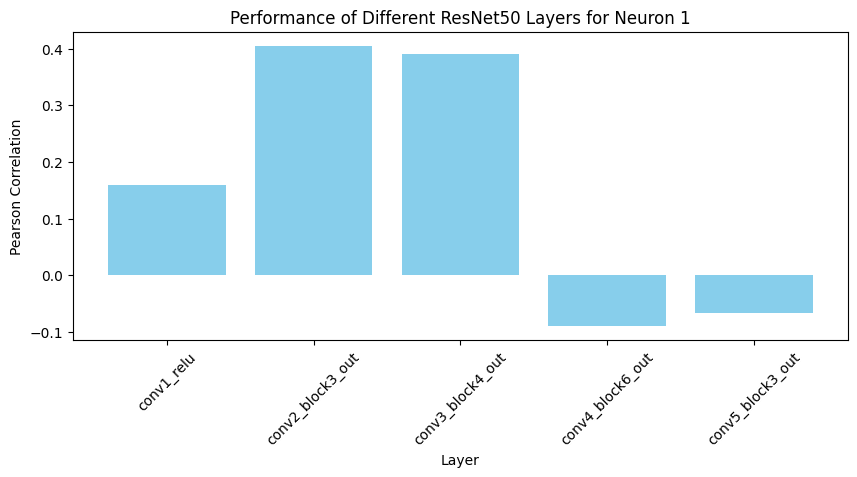

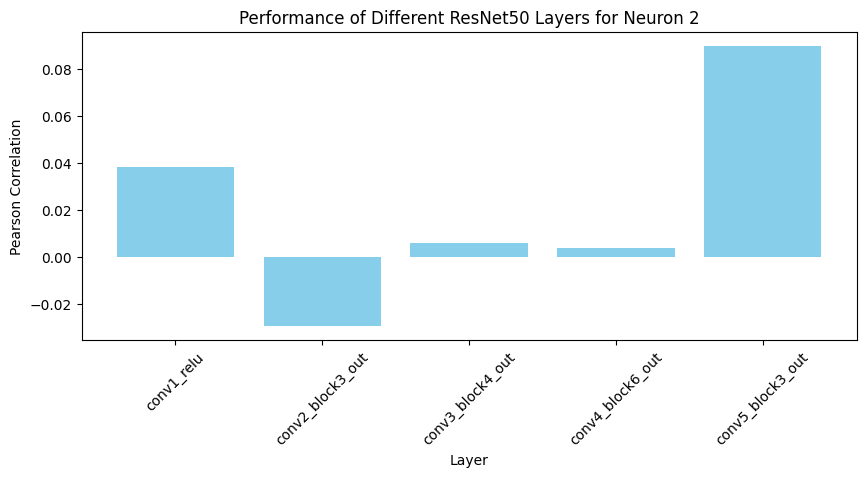

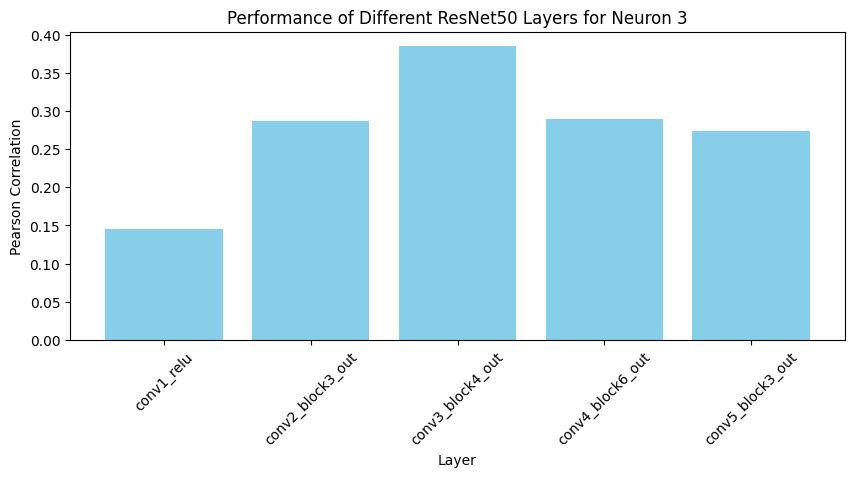

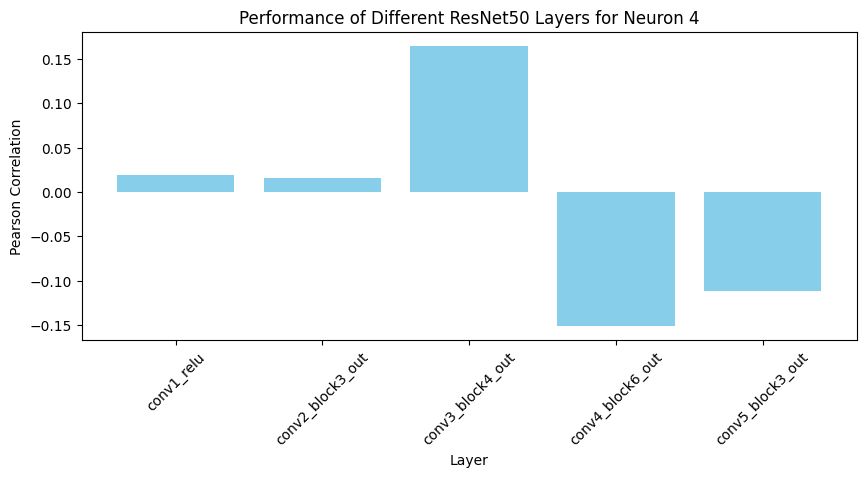

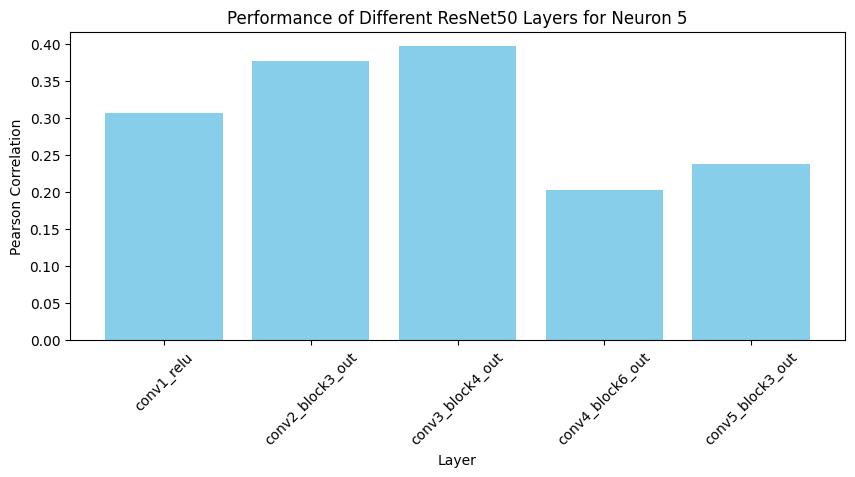

In [28]:
# Plotting results for each neuron
for neuron_index, neuron_metrics in enumerate(performance_metrics.values()):
    plt.figure(figsize=(10, 4))
    plt.bar(neuron_metrics.keys(), neuron_metrics.values(), color='skyblue')
    plt.xlabel('Layer')
    plt.ylabel('Pearson Correlation')
    plt.title(f'Performance of Different ResNet50 Layers for Neuron {neuron_index + 1}')
    plt.xticks(rotation=45)
    plt.show()

Resnet with different layers & elasticnet;
add cross validation

In [30]:
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import ElasticNet
import scipy.stats
import matplotlib.pyplot as plt

neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
trainfiles = [join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))]
trainfiles = sorted(trainfiles)

def load_image(im_file):
    image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return tf.keras.applications.resnet50.preprocess_input(image)

train_dataset = tf.data.Dataset.from_tensor_slices(trainfiles)
train_dataset = train_dataset.map(load_image).batch(10)
train_iterator = list(train_dataset.as_numpy_iterator())

base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, input_shape=(224, 224, 3))
layers_of_interest = ['conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
features_from_layers = {}

for layer in layers_of_interest:
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    train_features = []
    for image_batch in train_iterator:
        activation = model(image_batch, training=False)
        activation_pooled = tf.nn.max_pool2d(activation, ksize=(2, 2), strides=(2, 2), padding="SAME")
        train_features.append(activation.numpy())
    train_features = np.concatenate(train_features, axis=0)
    train_features = np.reshape(train_features, (train_features.shape[0], -1))
    features_from_layers[layer] = train_features

number_of_neurons = neural_response_train.shape[1]
performance_metrics = {}

# Define a k-fold cross-validator
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for neuron_index in range(number_of_neurons):
    neuron_performance = {}

    for layer, features in features_from_layers.items():
        model = ElasticNet(alpha=0.1, l1_ratio=0.7)

        cv_scores = cross_val_score(model, features, neural_response_train[:, neuron_index], cv=kfold,
                                    scoring='r2')  

        neuron_performance[layer] = np.mean(cv_scores)

    performance_metrics[f"Neuron {neuron_index + 1}"] = neuron_performance

for neuron, layers in performance_metrics.items():
    best_layer = max(layers, key=layers.get)
    best_score = layers[best_layer]
    print(f"Best performing layer for Neuron {neuron}: {best_layer} with average R2 score: {best_score:.3f}")
    for layer, score in layers.items():
        print(f"Layer: {layer}, Average R2 Score: {score:.3f}")
    print("\n")


Best performing layer for Neuron Neuron 1: conv3_block4_out with average R2 score: -0.104
Layer: conv1_relu, Average R2 Score: -0.433
Layer: conv2_block3_out, Average R2 Score: -0.374
Layer: conv3_block4_out, Average R2 Score: -0.104
Layer: conv4_block6_out, Average R2 Score: -0.211
Layer: conv5_block3_out, Average R2 Score: -0.673


Best performing layer for Neuron Neuron 2: conv3_block4_out with average R2 score: -0.113
Layer: conv1_relu, Average R2 Score: -0.120
Layer: conv2_block3_out, Average R2 Score: -0.147
Layer: conv3_block4_out, Average R2 Score: -0.113
Layer: conv4_block6_out, Average R2 Score: -0.145
Layer: conv5_block3_out, Average R2 Score: -0.215


Best performing layer for Neuron Neuron 3: conv2_block3_out with average R2 score: 0.112
Layer: conv1_relu, Average R2 Score: -0.137
Layer: conv2_block3_out, Average R2 Score: 0.112
Layer: conv3_block4_out, Average R2 Score: 0.095
Layer: conv4_block6_out, Average R2 Score: -0.109
Layer: conv5_block3_out, Average R2 Score: -0.1

VGG-16 with different layers and elasticnet


In [23]:
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import scipy.stats

def load_image(im_file):
    image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return tf.keras.applications.vgg16.preprocess_input(image)

def create_data_iterator(file_paths, batch_size=10):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_image).batch(batch_size)
    return list(dataset.as_numpy_iterator())

def get_features(model, layer_name, data_iterator, pool_size, pool_strides):
    partial_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = []
    for image_batch in data_iterator:
        activation = partial_model(image_batch, training=False)
        activation = tf.nn.max_pool2d(activation, ksize=pool_size, strides=pool_strides, padding="SAME")
        features.append(activation.numpy())
    return np.reshape(np.concatenate(features), (len(features) * 10, -1))

neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
test_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"

train_files = sorted([join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))])
test_files = sorted([join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))])

train_iterator = create_data_iterator(train_files)
test_iterator = create_data_iterator(test_files)

# Load VGG16 model
model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

layers_of_interest = ['block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv3']
pool_sizes_and_strides = {
    'block1_conv2': ((2, 2), (2, 2)),
    'block2_conv1': ((2, 2), (2, 2)),
    'block2_conv2': ((3, 3), (3, 3)),
    'block3_conv1': ((3, 3), (3, 3)),
    'block3_conv3': ((4, 4), (4, 4))
}

results = {}
for layer in layers_of_interest:
    pool_size, pool_strides = pool_sizes_and_strides[layer]
    train_feature = get_features(model, layer, train_iterator, pool_size, pool_strides)
    test_feature = get_features(model, layer, test_iterator, pool_size, pool_strides)

    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_feature)
    X_test = scaler.transform(test_feature)

    X_train, X_val, y_train, y_val = train_test_split(X_train, neural_response_train, test_size=0.3, random_state=42)

    clf = ElasticNet(alpha=0.1, l1_ratio=0.7)
    clf.fit(X_train, y_train)

    def score(predictions, true_values):
        return [scipy.stats.pearsonr(pred, true)[0] for pred, true in zip(predictions.T, true_values.T)]

    train_scores = score(clf.predict(X_train), y_train)
    val_scores = score(clf.predict(X_val), y_val)

    print(f"Results for {layer}:")
    for i in range(len(train_scores)):
        print(f"Neuron {i + 1}, train score = {train_scores[i]:.4f}, validation score = {val_scores[i]:.4f}")

for neuron in range(5):
    best_layer = max(neuron_performance[neuron], key=lambda x: neuron_performance[neuron][x]['score'])
    print(f"Neuron {neuron + 1} best layer: {best_layer} with score: {neuron_performance[neuron][best_layer]['score']:.4f}")


Results for block1_conv2:
Neuron 1, train score = 0.9318, validation score = 0.1466
Neuron 2, train score = 0.8746, validation score = 0.1281
Neuron 3, train score = 0.9548, validation score = 0.0565
Neuron 4, train score = 0.9521, validation score = -0.0489
Neuron 5, train score = 0.9573, validation score = 0.2853
Results for block2_conv1:
Neuron 1, train score = 0.9433, validation score = 0.2643
Neuron 2, train score = 0.8907, validation score = 0.2517
Neuron 3, train score = 0.9598, validation score = 0.1160
Neuron 4, train score = 0.9624, validation score = -0.0642
Neuron 5, train score = 0.9561, validation score = 0.3342
Results for block2_conv2:
Neuron 1, train score = 0.9361, validation score = 0.0222
Neuron 2, train score = 0.8905, validation score = 0.0307
Neuron 3, train score = 0.9510, validation score = 0.2006
Neuron 4, train score = 0.9602, validation score = -0.0036
Neuron 5, train score = 0.9461, validation score = 0.5108
Results for block3_conv1:
Neuron 1, train score =

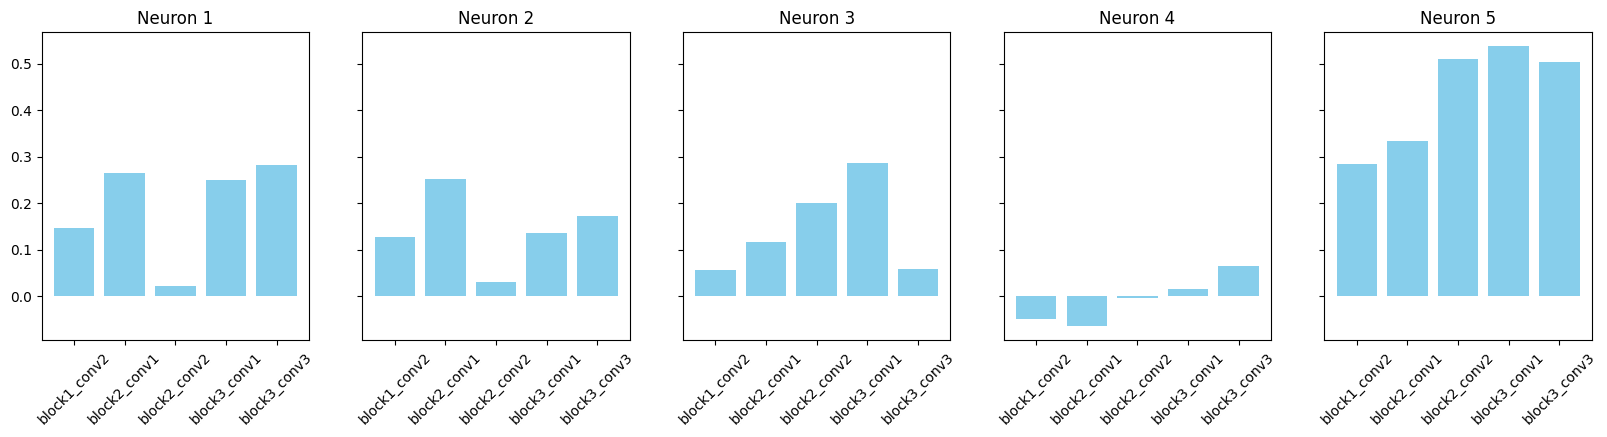

In [29]:
from matplotlib.ticker import FixedLocator

# Plotting the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)
for i in range(5):
    layers = list(neuron_performance[i].keys())
    scores = [neuron_performance[i][layer]['score'] for layer in layers]
    axs[i].bar(range(len(layers)), scores, color='skyblue')  
    axs[i].set_title(f'Neuron {i + 1}')
    axs[i].set_xticks(range(len(layers))) 
    axs[i].set_xticklabels(layers, rotation=45) 
    axs[i].xaxis.set_major_locator(FixedLocator(range(len(layers))))  
plt.show()


VGG-16 with different layers and elastic;
Add cross-validation

In [32]:
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import scipy.stats
import matplotlib.pyplot as plt

def load_image(im_file):
    image = tf.io.decode_jpeg(tf.io.read_file(im_file), channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return tf.keras.applications.vgg16.preprocess_input(image)

def create_data_iterator(file_paths, batch_size=10):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_image).batch(batch_size)
    return list(dataset.as_numpy_iterator())

def get_features(model, layer_name, data_iterator, pool_size, pool_strides):
    partial_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    features = []
    for image_batch in data_iterator:
        activation = partial_model(image_batch, training=False)
        activation = tf.nn.max_pool2d(activation, ksize=pool_size, strides=pool_strides, padding="SAME")
        features.append(activation.numpy())
    return np.reshape(np.concatenate(features), (len(features) * 10, -1))

neural_response_train = np.load("/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/neural_responses_train.npy")
train_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/train"
test_path = "/content/Computational-Neuroscience-Class/Project Option 1 Neural Fitting/images/test"

train_files = sorted([join(train_path, f) for f in listdir(train_path) if isfile(join(train_path, f))])
test_files = sorted([join(test_path, f) for f in listdir(test_path) if isfile(join(test_path, f))])

train_iterator = create_data_iterator(train_files)
test_iterator = create_data_iterator(test_files)
# Load VGG16 model
model = tf.keras.applications.VGG16(include_top=False, input_shape=(224, 224, 3))

layers_of_interest = ['block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv3']
pool_sizes_and_strides = {
    'block1_conv2': ((2, 2), (2, 2)),
    'block2_conv1': ((2, 2), (2, 2)),
    'block2_conv2': ((3, 3), (3, 3)),
    'block3_conv1': ((3, 3), (3, 3)),
    'block3_conv3': ((4, 4), (4, 4))
}

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_layers = {}
best_scores = {}

for layer in layers_of_interest:
    pool_size, pool_strides = pool_sizes_and_strides[layer]
    features = get_features(model, layer, train_iterator, pool_size, pool_strides)

    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    scores = []
    for train_index, val_index in kf.split(features):
        X_train, X_val = features[train_index], features[val_index]
        y_train, y_val = neural_response_train[train_index], neural_response_train[val_index]

        clf = ElasticNet(alpha=0.1, l1_ratio=0.7)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        scores.append([scipy.stats.pearsonr(y_val[:, i], predictions[:, i])[0] for i in range(y_val.shape[1])])

    average_scores = np.mean(scores, axis=0)

    for i, score in enumerate(average_scores):
        if i + 1 not in best_scores or score > best_scores[i + 1]:
            best_scores[i + 1] = score
            best_layers[i + 1] = layer

    print(f"Results for {layer}:")
    for i, score in enumerate(average_scores):
        print(f"Neuron {i + 1}, average validation score = {score:.4f}")

print("\nBest performing layers for different neurons:")
for neuron, layer in best_layers.items():
    print(f"Neuron {neuron}: {layer}, Validation Accuracy: {best_scores[neuron]:.4f}")


Results for block1_conv2:
Neuron 1, average validation score = -0.0810
Neuron 2, average validation score = 0.0771
Neuron 3, average validation score = 0.0789
Neuron 4, average validation score = -0.0295
Neuron 5, average validation score = 0.1503
Results for block2_conv1:
Neuron 1, average validation score = -0.0362
Neuron 2, average validation score = 0.0531
Neuron 3, average validation score = 0.0930
Neuron 4, average validation score = -0.0657
Neuron 5, average validation score = 0.2515
Results for block2_conv2:
Neuron 1, average validation score = 0.1114
Neuron 2, average validation score = -0.0167
Neuron 3, average validation score = 0.2150
Neuron 4, average validation score = -0.0548
Neuron 5, average validation score = 0.3378
Results for block3_conv1:
Neuron 1, average validation score = 0.2061
Neuron 2, average validation score = 0.0246
Neuron 3, average validation score = 0.4038
Neuron 4, average validation score = -0.0404
Neuron 5, average validation score = 0.4736
Results f